In [82]:
workdir = '/SNS/users/lj7/dv/sns-chops/detcalib/ARCS/out'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/detcalib/ARCS/out


# Explore

In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np, os
from mantid import simpleapi as msa, mtd

IPTS-19579. run 95840. Vanadium 3x3cm2. Ei 60meV. FC 420HZ. T0 60Hz.

Read data

In [52]:
runs= [95861, 95863, 95865, 95867, 95869, 95871, 95873, 95875]
filelist = ['ARCS_%s_event.nxs' % r for r in runs]

Calculate Ei and T0

In [53]:
Eis = []; T0s = []
for f in filelist:
    print f
    mons = msa.LoadNexusMonitors(f)
    Ei, T0 = msa.GetEiT0atSNS(mons)
    Eis.append(Ei)
    T0s.append(T0)
    continue
Ei = np.mean(Eis)
T0 = np.mean(T0s)
Ei, T0

ARCS_95861_event.nxs
ARCS_95863_event.nxs
ARCS_95865_event.nxs
ARCS_95867_event.nxs
ARCS_95869_event.nxs
ARCS_95871_event.nxs
ARCS_95873_event.nxs
ARCS_95875_event.nxs


(59.320433429204641, 29.972871089709656)

In [55]:
# Eis, T0s

In [56]:
files = '+'.join(filelist)
w = msa.Load(files)

Get vi

In [57]:
Ei, T0

(59.320433429204641, 29.972871089709656)

In [58]:
vi = 437.4*np.sqrt(Ei)
vi

3368.8442775435583

Get L1, t1

In [59]:
instr = w.getInstrument()

In [60]:
print instr.getSource().getPos()
print instr.getSample().getPos()

[0,0,-13.6]
[0,0,0]


In [61]:
L1 = (instr.getSample().getPos() - instr.getSource().getPos())[-1]

In [62]:
L1

13.6

In [63]:
t1 = L1/vi*1e6
t1

4036.9927724639847

To histogram

In [64]:
msa.Rebin(InputWorkspace=w, OutputWorkspace=w, Params="0,1.,16667")

EventWorkspace
Title: 95861 Vanadium on rotator 0deg Ch2 60meV 420Hz T0 30Hz coll DOWN
Histograms: 117760
Bins: 16667
Histogram
X axis: Time-of-flight / microsecond
Y axis: Counts
Distribution: False
Instrument: ARCS (2012-Oct-11 to 2100-Jan-31)Instrument from: /SNS/software/miniconda2/envs/py2/instrument/ARCS_Definition_20121011-.xml

Parameters from: /SNS/software/miniconda2/envs/py2/instrument/ARCS_Parameters.xml
Run start: 2017-Jul-15 13:58:50
Run end:  2017-Jul-15 15:06:53

Events: 116156960

Nominal L2

In [65]:
L2 = np.linalg.norm(instr.getDetector(40000).getPos())
L2

2.9927453074556238

In [66]:
(L1+L2)/vi * 1e6 + T0

4955.3252888495672

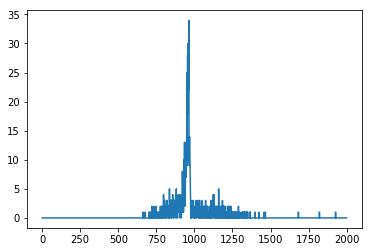

In [67]:
plt.plot(w.readY(40000)[4000:6000])

Simple estimate of peak position

In [68]:
t = np.argmax(w.readY(40000))
t

4963

In [69]:
t2 = t - t1 - T0
t2

896.03435644630565

In [70]:
d = t2*vi/1e6
d

3.018600214196562

Pretty close

In [71]:
print d, L2

3.0186002142 2.99274530746


Better estimate of peak position

In [72]:
tof_0 = (L1+L2)/vi * 1e6 + T0
print tof_0

4955.32528885


In [73]:
spectrum_number = 40000
spectrum = w.readY(spectrum_number)
center_bin = int(tof_0)
subset = spectrum[center_bin-100: center_bin+100]
center = np.dot(subset, np.arange(center_bin-100+.5, center_bin+100+.5))/np.sum(subset)
print center

4949.6584507


In [74]:
t = center
print (t - t1 - T0)*vi/1e6, L2

2.9736546122 2.99274530746


# Now go through all pixels

In [75]:
N = w.getNumberHistograms()

In [76]:
def iterL2(min_counts=20):
    for i in range(N):
        if i%10000==0: print i
        sp = w.getSpectrum(i)
        pixelID = sp.getDetectorIDs()[0]
        spectrum = w.readY(i)
        nominal_L2 = np.linalg.norm(instr.getDetector(pixelID).getPos())
        tot_counts = np.sum(spectrum)
        if tot_counts == 0:
            yield i, pixelID, nominal_L2, -1, tot_counts # dets not installed
            continue
        nominal_TOF = (L1+nominal_L2)/vi * 1e6 + T0
        center_bin = int(nominal_TOF)
        subset = spectrum[center_bin-100: center_bin+100]
        center = np.dot(subset, np.arange(center_bin-100+.5, center_bin+100+.5))/np.sum(subset)
        t = center
        L2 = (t - t1 - T0)*vi/1e6
        # assert abs(nominal_L2-L2)/nominal_L2<0.1
        yield i, pixelID, nominal_L2, L2, tot_counts
        continue

In [77]:
%%time
L2s = list(iterL2(min_counts=1))

0


/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning:

invalid value encountered in double_scalars



10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
CPU times: user 13min 31s, sys: 5min 10s, total: 18min 41s
Wall time: 41.8 s


In [31]:
#Debug code:
#for spectrumNo, pixelID, L2_0, L2, tot_counts in L2s:
#    if L2 < 0: continue
#    if L2 == 0 or abs(L2_0-L2)/L2_0 > 0.01:
#        print spectrumNo, pixelID, L2_0, L2, tot_counts

In [32]:
#Debug code:
#L2s[:10]

In [89]:
L2table = msa.CreateEmptyTableWorkspace()

In [79]:
%%time
L2table.addColumn(type='int', name='detid')
L2table.addColumn(type='float', name="L2")
L2table.addColumn(type='int', name="nodata")

for spectrumNo, pixelID, L2_0, L2, tot_counts in L2s:
    row = dict(detid=pixelID, L2=L2, nodata=int(L2<0 or tot_counts<100))
    L2table.addRow(row)

CPU times: user 471 ms, sys: 131 ms, total: 603 ms
Wall time: 496 ms


In [83]:
msa.SaveNexus(L2table, 'L2table.nxs')

In [85]:
ls

L2table.nxs


In [88]:
L2s[:1024]

[(0, 0, 3.517328557280551, 3.5155047451342365, 2.0),
 (1, 1, 3.5137600325776206, 3.5009064199315487, 5.0),
 (2, 2, 3.5102054800849598, 3.5153363029203581, 27.0),
 (3, 3, 3.5066649422916187, 3.4900315541935121, 80.0),
 (4, 4, 3.5031384616905568, 3.470341176538418, 268.0),
 (5, 5, 3.4996260807769568, 3.4866573581119638, 719.0),
 (6, 6, 3.4961278420465236, 3.4815718751714715, 958.0),
 (7, 7, 3.4926437879937717, 3.4858525088149395, 908.0),
 (8, 8, 3.4891739611102914, 3.4785547461155732, 909.0),
 (9, 9, 3.4857184038830047, 3.4727111790294041, 944.0),
 (10, 10, 3.4822771587924017, 3.4707988340335207, 920.0),
 (11, 11, 3.4788502683107652, 3.4722824214630892, 947.0),
 (12, 12, 3.4754377749003766, 3.4589830244776731, 904.0),
 (13, 13, 3.4720397210117113, 3.4623551666938126, 988.0),
 (14, 14, 3.4686561490816126, 3.4444447207959645, 1001.0),
 (15, 15, 3.4652871015314566, 3.4500658236536053, 965.0),
 (16, 16, 3.4619326207652974, 3.4543692451868493, 979.0),
 (17, 17, 3.4585927491680026, 3.448686672